<a href="https://colab.research.google.com/github/rohanblueboybaijal/assignments/blob/main/190714/Normalizing_Flows/RNVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow_probability as tfp
tfd = tfp.distributions 

In [33]:
def plot_samples_2d(data, name=None):
    # plt.figure(figsize=(5,5))
    # plt.xlim([-5, 5])
    # plt.ylim([-5, 5])
    plt.scatter(data[:, 0], data[:, 1]) 
    
    if name:
        plt.savefig('./demo/%s'%(name) + ".png", format="png")

In [34]:
# This function creates a multivariate GMM 
def createGMM(pi, mu, scale):
  mvgmm = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=pi),
      components_distribution=tfd.MultivariateNormalTriL(
          loc=mu,
          scale_tril=scale)
  )
  return mvgmm

In [35]:
pi = [0.3, 0.3, 0.4]
mu = [[8.0, 11.0], [3.0, 4.0], [-4.5, 1.0]]
cov = [ [[1.0, 0.0],[0.0, 1.0]], [[1.5, 0.3],[0.3, 0.3]], [[0.5, 0.0],[0.0, 2.0]]]
scale = tf.linalg.cholesky(cov)

In [36]:
mvgmm = createGMM(pi=pi, mu=mu, scale=scale)

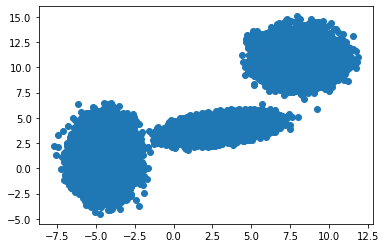

In [37]:
data=mvgmm.sample(100000)
plt.scatter(data[:,0], data[:,1])

Base Distribution is a Uniform Distribution

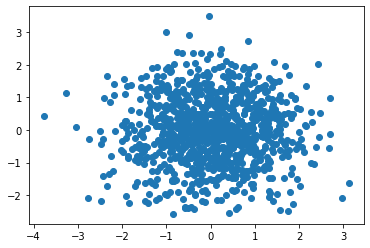

In [38]:
# base_dist = tfd.Uniform(low=[0.0, 0.0], high=[2.0, 2.0])
base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2])) #, tf.float32))
samples_u=base_dist.sample(1000)
plt.scatter(samples_u[:,0], samples_u[:,1])

**RNVP**

In [39]:
class NN(layers.Layer):
    """
    Neural Network Architecture for calcualting s and t for Real-NVP
    
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    :param activation: Activation of the hidden units
    """
    def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.log_s_layer = layers.Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = layers.Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

In [40]:
class RealNVP:
    """
    Implementation of a Real-NVP for Density Estimation. L. Dinh “Density estimation using Real NVP,” 2016.
    This implementation only works for 1D arrays.
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    """

    def __init__(self, input_shape, flip):
        assert input_shape % 2 == 0
        input_shape = input_shape // 2
        nn = NN(input_shape)
        x = keras.Input(input_shape)
        log_s, t = nn(x)
        self.nn = keras.Model(x, [log_s, t], name="nn")
        self.flip = flip
        #print(self.nn.summary())
        
    def _forward(self, u):
        u1, u2 = tf.split(u, 2, axis=-1)

        if self.flip == True:
          u1, u2 = u2, u1

        x1 = u1
        log_s, mu = self.nn(u1)
        x2 = u2 * tf.exp(log_s) + mu 

        if self.flip == True:
          x1, x2 = x2, x1
        
        x = tf.concat([x1, x2], axis=-1)
        return x, log_s

    def _inverse(self, x):
        x1, x2 = tf.split(x, 2, axis=-1)

        if self.flip == True:
          x1, x2 = x2, x1
        
        u1 = x1
        log_s, mu = self.nn(x1)
        u2 = (x2 - mu)/tf.exp(log_s)

        if self.flip == True:
          u1, u2 = u2, u1
        
        u = tf.concat([u1, u2], axis=-1)
        return u, log_s

In [41]:
n = 4
flip = False
rnvp_chain = []
for i in range(n):
  rnvp_chain.append(RealNVP(2,flip))
  flip = not flip

In [42]:
def complete_inverse(x):
  u = x
  log_det_jacob_inv_transf = 0
  for i in range(n-1,-1,-1):
    u, log_s = rnvp_chain[i]._inverse(u)
    log_det_jacob_inv_transf = log_det_jacob_inv_transf - log_s
  return u, log_det_jacob_inv_transf

def complete_forward(u):
  x = u
  log_det_jacob_forward_transf = 0
  for i in range(n):
    x, log_s = rnvp_chain[i]._forward(x)
    log_det_jacob_forward_transf = log_det_jacob_forward_transf + log_s
  return x, log_det_jacob_forward_transf

In [43]:
#complete this function
# @tf.function
def train_density_estimation(data_batch, rnvp_chain, base_dist, optimizer): #batch):
    """
    Train function for density estimation normalizing flows.
    """
    with tf.GradientTape() as tape:
        u, log_det_jacob_inv_transf = complete_inverse(data_batch)
        loss = -tf.reduce_mean(base_dist.log_prob(u) + log_det_jacob_inv_transf)

    gradients = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [44]:
dataset_size = 100000
data = np.array(data)
epochs = 5
optimizer = optimizers.Adam(learning_rate = 0.001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
    for j in range(batches_per_epoch):
        data_batch = data[batch_size*j:batch_size*(j+1)]
        last_loss = train_density_estimation(data_batch, rnvp_chain, base_dist, optimizer)
    print(last_loss)

tf.Tensor(3.975398, shape=(), dtype=float32)
tf.Tensor(3.8485548, shape=(), dtype=float32)
tf.Tensor(3.8327775, shape=(), dtype=float32)
tf.Tensor(3.803121, shape=(), dtype=float32)
tf.Tensor(3.7314062, shape=(), dtype=float32)


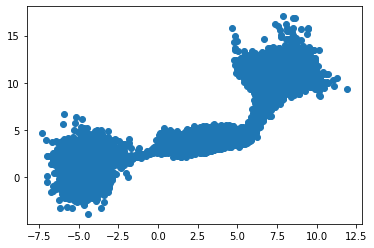

In [45]:
test_samples_u = base_dist.sample(10000)
test_samples_x, _ = complete_forward(test_samples_u)
plot_samples_2d(test_samples_x)